In [ ]:
import numpy as np
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

arr = np.load("logits_class_raw")

arr = arr.reshape(-1, 1024)

arr = torch.from_numpy(arr)

arr = F.sigmoid(arr).round().float()

ans = np.zeros(shape=(arr.shape[0],))

for i, sample in enumerate(arr):
    idx = sample.nonzero()[0]
    ans[i] = idx
# np.save("logits_class.npy", ans)

torch.Size([4998, 1024])


(4998,)


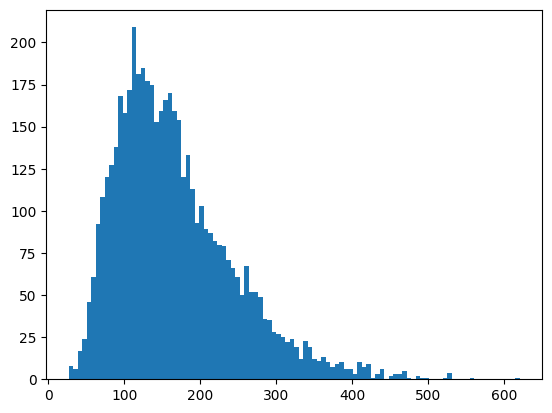

In [36]:
import matplotlib.pyplot as plt
arr = np.load("logits_regr_old.npy")
print(arr.shape)
plt.hist(arr, bins = 100)
plt.show()

In [38]:
# Only for the logits classifier. Plot the performance as a function of the threshold.
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# dir1/dir2/this_file.py
# I want to get
# dir1/data/test.csv
path_to_test = os.path.join(
    "..",
    "data",
    "test.csv"
)

# Read in the prompts
df = pd.read_csv(path_to_test)

# Init the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "GSAI-ML/LLaDA-8B-Instruct"
)

# Get GT lengths
gt = [
    len(tokenizer(response)["input_ids"])
    for response in df.model_response.dropna()
]
n_test_samples = len(gt)
print(f"Evaluating {n_test_samples} test instances...")

# Load logits
logits = np.load("logits_class_raw")
logits = logits.reshape(-1, 1024)
logits = torch.from_numpy(logits)
probs = F.sigmoid(logits)

# Get prediction per threshold
thresh = np.arange(0, 1, 0.1)
preds = {
    thr:np.zeros(shape=(len(gt),))
    for thr in thresh
}
for thr in thresh:
    # Preds for this thresh
    tmp = torch.greater_equal(probs, thr).float()

    for i, sample in enumerate(tmp):   
        idx = sample.nonzero()[0]
        preds[thr][i] = idx

# Store results
ans = {
    thr:{
        "above":[],
        "below":[],
        "exact":[]
    } for thr in thresh
}

for i in tqdm(range(len(gt))):
    
    # Get true
    true = gt[i]

    # Evaluate each pred
    for thr in thresh:
        
        # Pred for this model
        pred = preds[thr][i]
        
        # Model predict exact length
        if pred == true:
            # print(f"Wow! {model} predicted the exact length ({pred}) of the {i}-th test instance!")
            k = "exact"
        # Model predicted more than true length (good)
        elif pred > true:
            k = "above"
        # Model predicted less than true length (bad)
        elif pred < true:
            k = "below"

        # Store the tuple in the correct place
        ans[thr][k].append(
                (pred-true).item()
            )

# Get aggregate metrics
ans_df = pd.DataFrame(
    columns=[
        "Model",
        "Below",
        "Above",
        "Exact",
        "Below_avg",
        "Above_avg"
    ]
)

for i, model in enumerate(preds.keys()):
    
    # The model name
    ans_df.loc[i, "Model"] = model
    
    # How many above, below, exact predicted (with avg)
    for k in ["above", "below", "exact"]:
        ans_df.loc[i, k.capitalize()] = len(ans[model][k]) / n_test_samples * 100
        if k != "exact":
            ans_df.loc[i, f"{k.capitalize()}_avg"] = np.mean(ans[model][k]).item()

    # Compute mse
    ans_df.loc[i, "MSE"] = np.mean(
        np.power(
            ans[model]["above"] + ans[model]["below"] + ans[model]["exact"],
            2
        )
    ).item()

# ans_df = ans_df.set_index("Model")
ans_df['Model'] = ans_df['Model'].apply(lambda x: f"{x:.1f}")
# Print the result
# print(ans_df.to_string())


Evaluating 4998 test instances...


100%|██████████| 4998/4998 [00:00<00:00, 94563.55it/s]
/home/brimax/miniconda3/envs/brimax/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brimax/miniconda3/envs/brimax/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [29]:
ans_df

,Model,Below,Above,Exact,Below_avg,Above_avg,MSE
0,0.0,100.0,0.0,0.0,-193.217487,NaN,50551.552821
1,0.1,58.223289,41.336535,0.440176,-93.227835,61.088093,10709.041417
2,0.2,39.415766,60.064026,0.520208,-80.466497,81.332778,10205.890356
3,0.3,28.791517,70.728291,0.480192,-73.148019,97.694484,12272.623049
4,0.4,22.04882,77.771108,0.180072,-67.274047,112.463854,15276.301120
5,0.5,17.246899,82.513005,0.240096,-61.448956,126.690107,18859.420368
6,0.6,12.885154,86.834734,0.280112,-59.416149,140.370046,23198.698679
7,0.7,9.443778,90.516206,0.040016,-55.302966,155.501326,28542.859744
8,0.8,6.502601,93.457383,0.040016,-49.830769,175.787626,36339.044618
9,0.9,3.201281,96.718687,0.080032,-46.89375,207.03765,50326.483193


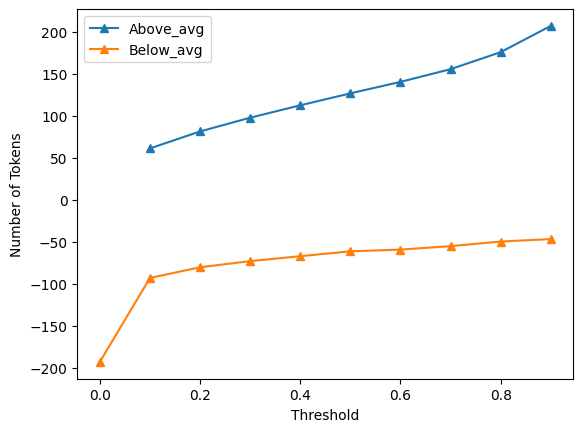

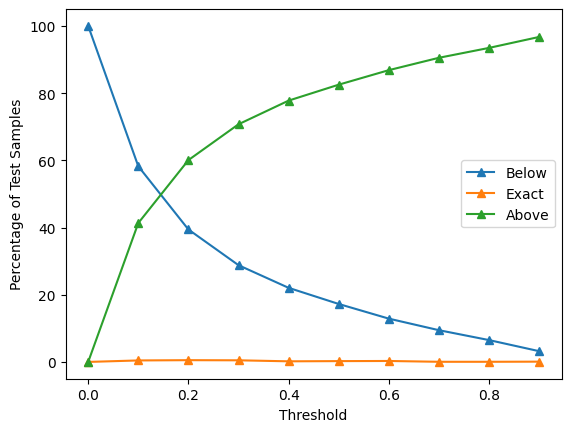

In [53]:
ans_df.plot(
    x = "Model",
    y=[
        "Above_avg",
        "Below_avg"
    ],
    marker = "^")
plt.xlabel("Threshold")
plt.ylabel("Number of Tokens")
plt.savefig("avgs_thresh.png")

ans_df.plot(
    x = "Model",
    y=[
        "Below",
        "Exact",
        "Above"
    ],
    marker = "^")
plt.xlabel("Threshold")
plt.ylabel("Percentage of Test Samples")
plt.savefig("perc_avgs.png")